In [1]:
import numpy as np
from astropy.cosmology import Planck18 as cosmo
import astropy.constants as cst
import astropy.units as u
import pylab as plt
from galpy.potential import evaluatePotentials
from scipy import integrate, differentiate, interpolate
from scipy.signal import find_peaks

# 1. Einstein Radius

For a point‐mass lens, the angular Einstein radius is given by:
$$
\theta_E = \sqrt{\frac{4GM_l}{c^2}\frac{D_{ls}}{D_lD_s}}
$$
where\
$G$ is the gravitational constant, \
$M_l$ is the lens mass,\
$c$ is the speed of light,\
$D_l$ is the angular diameter distance to the lens,\
$D_s$ is the angular diameter distance to the source,\
$D_{ls}$ is the angular-diameter distance between lens and source, which is not necessarily equal to $D_s - D_l$.

In [2]:
def theta_E(M,Dl,Ds,Dls=None):
    c = cst.c
    G = cst.G
    if Dls == None:
        Dls = Ds-Dl
    return np.sqrt((4*G*M/c**2)/(Dl*Ds/Dls)).to(u.arcsec,equivalencies=u.dimensionless_angles())

In [3]:
theta_E(1e2*cst.M_sun,0.5*u.kpc,1*u.Mpc)

<Quantity 0.04034794 arcsec>

# 2. Time Delay in Microlensing

Some idea developed from https://galaxiesbook.org/chapters/III-04.-Gravitational-Lensing.html

In gravitational lensing by a point mass, each image has a different _fermat potential_. For a given image at angular position $\theta$, the source at angular position $\beta$, the _fermat potential_ $\tau$ is given by:
$$
\tau(\theta) = \left[
\frac{1}{2}({\bm \theta} - {\bm \beta})^2 - \psi(\theta)
\right].
$$
This is a critical term for the lensing time delay, as $\Delta t(\theta) = (1+z_l)\dfrac{D_lD_s}{cD_{ls}}\tau(\theta)$, and lensing only occured at the minimum of the fermat potential due to the _fermat principle_.
 
The lensing potential is defined as:
$$
\psi = \frac{D_{ls}}{D_sD_l}\frac{2}{c^2}\int \mathrm{d}r_\perp \Phi(D_l{\bm\theta},r_\perp)
$$
where $\Phi$ is the Gravitational potential. Assuming a minimal perpendicular distance $r_\perp$ dependence, we can write a Laplacian of the lensing potential with (Bovy, 16.31):
$$
\nabla_\theta \psi = 2\kappa(\theta) = 4\pi G \frac{D_{ls}D_l}{D_s}\frac{2}{c^2}\Sigma(R,\phi)
$$
where 
$$
\begin{aligned}
\Sigma(R,\phi) &= \int \mathrm{d}r_\perp\left[\rho(R_\parallel,\phi,r_\perp) + \frac{1}{4\pi G}\frac{\partial^2\Phi(R,\phi,z)}{\partial z^2}\right]\\
&= \kappa(\theta)\dfrac{c^2}{4\pi G}\dfrac{D_s}{D_{ls}D_l}
\end{aligned}
$$
is the surface mass density, and $\kappa(\theta)$ is the lensing convergence, both would be able to connect to the weak lensing formalism. 

Solving the Poisson equation would be able to give the solution for $\psi(\theta)$:
$$
\begin{aligned}
\psi({\bm \theta}) &= \frac{1}{\pi} \int \mathrm{d}^2{\bm \theta}'\kappa({\bm \theta}') \ln|{\bm \theta} - {\bm\theta'}| \\
&= 2\int_0^{|\bm \theta|} \theta' \mathrm{d}\theta' \kappa({\theta}') \ln\left(\frac{|{\bm \theta}|}{\theta'}\right) \mathrm{(Axial-symmetric)} \\
\end{aligned}
$$

The error of the propagation time is defined as:
$$
\sigma_{\Delta t} = \left(\dfrac{\rho_s}{\theta_E}\right)^2\Delta t
$$
where $\rho_s$ is the apparent angular radius of the source, the source angular radius after being lensed. We start with the fermat principle as the lensed image only occurred at the local minima $\theta_*$ of the fermat potential:
$$
\theta_* - \beta = \frac{\partial \psi(\theta_*)}{2\partial\theta}.
$$
We then perturb $\beta$ by $\theta_s$, the unlensed source angular radius:
$$
\theta_* \pm \rho_s - \beta \mp \theta_s = \frac{1}{2}\psi'_\theta(\theta_*\pm\rho_s).
$$
Let's assume $\theta_s \ll \beta$ as well as $\rho_s \ll |\theta_*|$. The first assumption is not always correct, but the second can be considered so:
$$
\begin{aligned}
\theta_* \pm \rho_s - \beta \mp \theta_s &= \frac{1}{2}\psi'_\theta(\theta_*)\pm\frac{1}{2}\psi''_\theta(\theta_*)\rho_s. \\
\pm \rho_s \mp \theta_s &= \frac{1}{2}\psi''_\theta(\theta_*)\rho_s \\
\left(\pm 1 - \frac{1}{2}\psi''_\theta(\theta_*) \right) \rho_s &= \pm \theta_s \\
\rho_s &= \dfrac{\pm \theta_s}{\left(\pm 1 - \frac{1}{2}\psi''_\theta(\theta_*)\right)}
\end{aligned}
$$

In [7]:
def lensing_potential(Pot,theta,zlens=None,zsource=None,zmax=np.inf,DL=None,DS=None):
    if DL is None:
        DL= cosmo.angular_diameter_distance(zlens)
    if DS is None:
        DS = cosmo.angular_diameter_distance(zsource)
        DLS = cosmo.angular_diameter_distance_z1z2(zlens,zsource)
    else:
        DLS = DS - DL
    cosmo_fac= DLS/DL/DS
    # Some gymnastics to deal with units
    R= (np.sqrt(theta[0]**2.+theta[1]**2.)*DL)\
        .to(u.kpc,equivalencies=u.dimensionless_angles())
    R= (R/(Pot[0]._ro if isinstance(Pot,list) else Pot._ro)/u.kpc)\
         .to_value(u.dimensionless_unscaled)
    phi= np.arctan2(theta[1],theta[0])
    # Result includes more gymnastics to deal with units
    return (cosmo_fac*2./cst.c**2.
            *integrate.quad(lambda z: evaluatePotentials(Pot,R,z,phi=phi,
                                                         use_physical=False),
                            -zmax,zmax)[0]
            *(Pot[0]._ro*Pot[0]._vo**2. if isinstance(Pot,list)
              else Pot._ro*Pot._vo**2.)*u.kpc*u.km**2/u.s**2)\
       .to(u.arcsec**2,equivalencies=u.dimensionless_angles())

def is_array(x):
    return isinstance(x, (list, tuple, np.ndarray))

def lensing_potential_pointmass(mass,theta,DL,DS,prec=100,verbose=False,mode='scipy'):
    DLS = DS - DL;cosmo_fac= DLS/DL/DS
    Rp = (theta*DL).to(u.kpc,equivalencies=u.dimensionless_angles())
    phi_ = lambda Rx: -1/np.sqrt(Rp**2+Rx**2)
    Rpf = np.float64(Rp)
    Rpfa = is_array(Rpf)
    if Rpfa == True:
        print(Rp[0],Rpf[0])
        phia = [lambda Rxf: np.float64(-1/np.sqrt(np.float64(Rpfi)**2+Rxf**2)) for Rpfi in Rp[0]]
    else:
        phi__ = lambda Rxf: np.float64(-1/np.sqrt(Rpf**2+Rxf**2))
    if mode == 'numpy' or verbose == True:
        LS_split = np.sqrt(DLS*10*Rp)
        L_split = np.sqrt(DL*10*Rp)
        Rx_arr_1 = np.linspace(-DLS,-LS_split,prec+1)[:-1]
        Rx_arr_2 = np.linspace(-LS_split,-3*Rp,6*prec+1)[:-1]
        Rx_arr_3 = np.linspace(-3*Rp,3*Rp,16*prec)
        Rx_arr_4 = np.linspace(3*Rp,L_split,6*prec+1)[1:]
        Rx_arr_5 = np.linspace(L_split,DL,prec+1)[1:]
        Rx_arr_far = np.append(Rx_arr_1,Rx_arr_2)
        Rx_arr_clo = np.append(Rx_arr_4,Rx_arr_5)
        Rx_arr = np.sort(np.append(np.append(Rx_arr_far,Rx_arr_3),Rx_arr_clo))
    potential = cosmo_fac*(2*cst.G*mass)/(cst.c**2)*\
        (np.trapz(phi_(Rx_arr),Rx_arr) if mode == 'numpy'
        else (integrate.quad(phi__,np.float64(-DLS.to(u.kpc)),np.float64(DL.to(u.kpc)))[0] if Rpfa == False
             else [integrate.quad(phii,np.float64(-DLS.to(u.kpc)),np.float64(DL.to(u.kpc)))[0] for phii in phia]))
    if verbose == False:
        if Rpfa == True:
            pot_arcsec2 = [pot.to(u.arcsec**2,equivalencies=u.dimensionless_angles()) for pot in potential]    
        else:
            return potential.to(u.arcsec**2,equivalencies=u.dimensionless_angles())
    else:
        return potential.to(u.arcsec**2,equivalencies=u.dimensionless_angles()),Rx_arr

def second_derivative(f, x, h=1e-2):
    return (f(x + h*x) - 2*f(x) + f(x - h*x)) / h**2

def lensing_potential_pointmass_2nd_order(mass,thetas,DL,DS,order=2):
    psi_theta = lambda vartheta: np.float64(lensing_potential_pointmass(mass,vartheta,DL,DS,verbose=False,mode='scipy'))
    return second_derivative(psi_theta,thetas)
    #if order == 1:
        #return differentiate.derivative(psi_theta, np.float64(thetas.to(u.arcsec))).df
    #elif order == 2:
        #psi_prime_theta = lambda theta: differentiate.derivative(psi_theta, theta).df
        #return differentiate.derivative(psi_prime_theta, np.float64(thetas.to(u.arcsec))).df

def rho_s(mass,thetas,theta_s,DL,DS):
    psi_theta = lensing_potential_pointmass(mass,thetas,DL,DS)
    psi_dbprime_theta = lensing_potential_pointmass_2nd_order(mass,thetas,DL,DS)
    rho_s_r0 = theta_s/(1 - 0.5*psi_dbprime_theta)
    rho_s_r1 = - theta_s/(- 1 - 0.5*psi_dbprime_theta)
    print("At theta_* = ",thetas)
    print("The psi(theta) is ",psi_theta)
    print("The psi^''(theta) is ",psi_dbprime_theta)
    print('With the lensed radius on both sides are: ',rho_s_r0,' and ',rho_s_r1)
    return 0.5*(rho_s_r0+rho_s_r1)

def fermat_potential(Pot,beta,theta,zlens=None,zsource=None,zmax=np.inf,DL=None,DS=None):
    return 0.5*np.sum((beta-theta)**2.)\
        -lensing_potential(Pot,theta,zlens=zlens,zsource=zsource,zmax=zmax,DL=DL,DS=DS)

def fermat_potential_pointmass(mass,beta,theta,DL,DS):
    return 0.5*(beta-theta)**2.\
        -lensing_potential_pointmass(mass,theta,DL,DS)

def arrival_time(Pot,beta,theta,zlens=None,zsource=None,zmax=np.inf,mass=None,DL=None,DS=None,pointmass=True):
    if pointmass == False:
        fermat = fermat_potential(Pot,beta,theta,zlens,zsource,zmax,DL,DS)
    if DL is None:
        DL= cosmo.angular_diameter_distance(zlens)
    elif DL < 100*u.Mpc:
        zlens = 0.0
    if DS is None:
        DS = cosmo.angular_diameter_distance(zsource)
        DLS = cosmo.angular_diameter_distance_z1z2(zlens,zsource)
    else:
        DLS = DS - DL
    if pointmass == True:
        fermat = fermat_potential_pointmass(mass,beta,theta,DL,DS)
    cosmo_fac= DLS/DL/DS
    return (1+zlens)/cosmo_fac/cst.c*fermat

def arrival_time_simple(mass,beta,theta,DL,DS):
    DLS = DS - DL
    fermat = fermat_potential_pointmass(mass,beta,theta,DL,DS)
    cosmo_fac= DLS/DL/DS
    return fermat/cosmo_fac/cst.c

def extrema(x,y):
    # Find position of extrema in y, where the lensing pattern must happen due to fermat principle
    indx= ((y > np.roll(y,1))*(y > np.roll(y,-1)))\
         +((y < np.roll(y,1))*(y < np.roll(y,-1)))
    # Remove edges
    ii= np.arange(len(x))
    indx*= (ii != 0)*(ii != (len(x)-1))
    return (x[indx],y[indx])

def minima(x,y):
    # Find position of minima in y, where the lensing pattern must happen due to fermat principle
    indx, _ = find_peaks(-y)
    # Remove edges
    ii= np.arange(len(x))
    #indx*= (ii != 0)*(ii != (len(x)-1))
    return (x[indx],y[indx])

In [8]:
def time_diff(M,beta,DL,DS,RS):
    DL0 = 1.0*DL; DS0 = 1.0*DS
    DL1 = 1.0*DL; DS1 = 1.0*DS
    tE = theta_E(M,DL,DS)
    tS = (RS/DS).to(u.arcsecond,equivalencies=u.dimensionless_angles())
    thetas_minus = np.linspace((beta-3*tE)*(beta/tE+1),(beta-0.03*tE)*(beta/tE+1),1000)
    thetas_plus = np.linspace((beta+0.03*tE)*(beta/tE+1),(beta+3*tE)*(beta/tE+1),1000)
    thetas = np.append(thetas_minus,thetas_plus)
    taus = u.Quantity([arrival_time_simple(M,beta,theta,DL,DS).to(u.second,equivalencies=u.dimensionless_angles()) for theta in thetas])
    delta_Ts = minima(thetas,taus)
    #beta_minus = beta-tS;beta_plus = beta+tS
    theta_1 = delta_Ts[0][0];theta_2 = delta_Ts[0][1]
    rho_source_1 = rho_s(M,theta_1,tS,DL,DS)
    rho_source_2 = rho_s(M,theta_2,tS,DL,DS)
    #theta_focused_1 = np.linspace(theta_1-10*tS,theta_1+10*tS,500)
    #theta_focused_2 = np.linspace(theta_2-10*tS,theta_2+10*tS,500)
    #theta_focused = np.append(theta_focused_1,theta_focused_2)
    #taus_minus = u.Quantity([arrival_time_simple(M,beta_minus,theta_focused,DL0,DS0).to(u.second,equivalencies=u.dimensionless_angles()) for theta in thetas])
    #delta_Ts_minus = minima(thetas,taus_minus)
    #taus_plus = u.Quantity([arrival_time_simple(M,beta_plus,theta_focused,DL1,DS1).to(u.second,equivalencies=u.dimensionless_angles()) for theta in thetas])
    #delta_Ts_plus = minima(thetas,taus_plus)
    plt.figure(dpi=100)
    line = plt.plot(thetas,taus)
    plt.plot(*minima(thetas,taus),'o',color=line[0].get_color())
    #plt.plot(*minima(thetas,taus_minus),'.',color=line[0].get_color(),alpha=0.5)
    #plt.plot(*minima(thetas,taus_plus),'.',color=line[0].get_color(),alpha=0.5)
    plt.axvline(beta.to_value(),color='k',ls='--',label='$\\beta$')
    plt.axvline((beta-tE).to_value(),color='r',ls=':',label='$\\theta_E$')
    plt.axvline((beta+tE).to_value(),color='r',ls=':')
    plt.legend()
    plt.ylabel('Time added')
    plt.xlabel('$\\theta$ [arcsec]')
    plt.show()
    if delta_Ts[1].shape[0] == 1:
        raise ValueError('only one lensed image!')
    elif delta_Ts[1].shape[0] >= 3:
        print(delta_Ts)
        raise ValueError('more than two images!')
    else:
        #atS_0 = np.abs(delta_Ts_minus[0][0]-delta_Ts_plus[0][0])
        #atS_1 = np.abs(delta_Ts_minus[0][1]-delta_Ts_plus[0][1])
        #atS = 0.5*(atS_0+atS_1)
        atS = 0.5*(rho_source_1+rho_source_2)
        print('original theta_s:',tS)
        print('rho_s = lensed theta_s:',atS)
        Delta_t = np.abs(delta_Ts[1][0]-delta_Ts[1][1])
        Delta_Delta_t = (atS/tE)**2*Delta_t
        return Delta_t,Delta_Delta_t

At theta_* =  -0.012712878110018387 arcsec
The psi(theta) is  -0.0028734408091595303 arcsec2
The psi^''(theta) is  -0.00016288520990771077
With the lensed radius on both sides are:  1.4210497701562954e-08 arcsec  and  1.4212812569992881e-08 arcsec
At theta_* =  0.012799727144130866 arcsec
The psi(theta) is  -0.002872331885133786 arcsec2
The psi^''(theta) is  -0.00016288520993373162
With the lensed radius on both sides are:  1.4210497701562769e-08 arcsec  and  1.4212812569993066e-08 arcsec


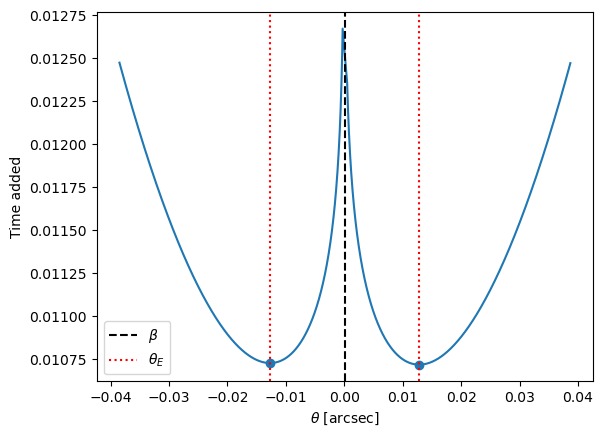

original theta_s: 1.421165504151346e-08 arcsec
rho_s = lensed theta_s: 1.4211655135777917e-08 arcsec


(<Quantity 9.26199614e-06 s>, <Quantity 1.14850788e-17 s>)

In [9]:
time_diff(30.0*u.Msun,0.0001*u.arcsec,1*u.kpc,3*u.kpc,1*u.R_earth)

# Below are only sanity checks

In [58]:
DL = 0.01*u.kpc
DS = 1*u.Mpc
M = 100*u.Msun
tE = theta_E(M,DL,DS,DS-DL)
tE

<Quantity 0.28537295 arcsec>

In [59]:
phi_pm = lensing_potential_pointmass(M,tE,DL,DS,prec=100,verbose=False)
phi_pm

<Quantity -1.62390714 arcsec2>

In [63]:
fermat_potential_pointmass(M,0.5*tE,tE,DL,DS)

<Quantity 1.63408686 arcsec2>

In [60]:
from galpy.potential import SphericalShellPotential
phi = SphericalShellPotential(amp=M,a=300.0*u.km)
lensing_potential(phi,u.Quantity([tE,0.*u.arcsec]),DL=DL,DS=DS)

/tmp/ipykernel_1900/155248561.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  *integrate.quad(lambda z: evaluatePotentials(Pot,R,z,phi=phi,



<Quantity -3.9677239 arcsec2>

In [95]:
fermat_potential(phi,u.Quantity([0.5*tE,0*u.arcsec]),u.Quantity([tE,0*u.arcsec]),DL=DL,DS=DS)

/tmp/ipykernel_1900/1553468412.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  *integrate.quad(lambda z: evaluatePotentials(Pot,R,z,phi=phi,



<Quantity 3.97790361 arcsec2>

/tmp/ipykernel_1900/155248561.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  else integrate.quad(phi__,np.float64(-DLS.to(u.kpc)),np.float64(DL.to(u.kpc)))[0])



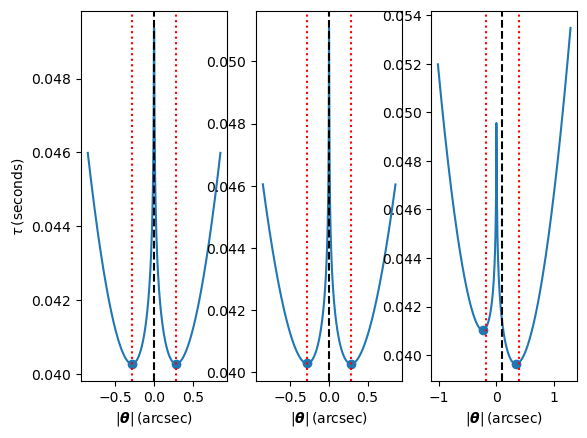

In [68]:
phi = SphericalShellPotential(amp=M,a=300.0*u.km)
#pep = PerfectEllipsoidPotential(amp=M,a=3*u.pc,b=1.,c=1.)
betas = [0.00001,0.001,0.1]*u.arcsec
for ii,beta in enumerate(betas):
    plt.subplot(1,len(betas),ii+1)
    #if np.fabs(beta) < 0.002:
    thetas = np.linspace((beta-3*tE)*(beta/tE+1),(beta+3*tE)*(beta/tE+1),500)
    #elif np.fabs(beta) < 0.02:
        #thetas= np.linspace(-0.015,0.015,1000)*u.arcsec
    #else:
        #thetas= np.linspace(-0.15,0.15,30)*u.arcsec
    #ploty2= u.Quantity([arrival_time(phi,u.Quantity([beta,0.*u.arcsec]),
                                      #u.Quantity([theta,0.*u.arcsec]),mass=M,pointmass=False,
    ploty2 = u.Quantity([arrival_time(phi,beta,theta,mass=M,
                                      DL=DL,DS=DS).to(u.second,equivalencies=u.dimensionless_angles())
                       for theta in thetas])
    line= plt.plot(thetas,ploty2)
    plt.plot(*minima(thetas,ploty2),'o',color=line[0].get_color())
    plt.axvline(beta.to_value(),color='k',ls='--')
    plt.axvline((beta-tE).to_value(),color='r',ls=':')
    plt.axvline((beta+tE).to_value(),color='r',ls=':')
    plt.xlabel(r'$|\boldsymbol{\theta}|\,(\mathrm{arcsec})$')
    if ii == 0:
        plt.ylabel(r'$\tau\,(\mathrm{seconds})$');
plt.show()

In [79]:
np.diff(minima(thetas,ploty2)[1])

<Quantity [-0.00138786] s>

/tmp/ipykernel_1213/1316398295.py:13: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  *integrate.quad(lambda z: evaluatePotentials(Pot,R,z,phi=phi,



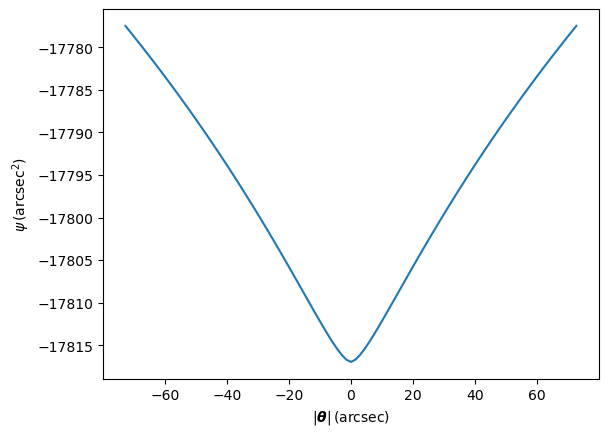

In [5]:
from galpy.potential import NFWPotential
nfw_phi= NFWPotential(mvir=10,conc=6.37,
                 H=67.1,overdens=200.,wrtcrit=True,
                 ro=8.,vo=220.)
zlens, zsource = 0.5, 1.
DL= cosmo.angular_diameter_distance(zlens)
thetas= np.linspace(-nfw_phi.rvir(H=67.1,overdens=200.,wrtcrit=True,use_physical=True)*u.kpc/DL,
                       nfw_phi.rvir(H=67.1,overdens=200.,wrtcrit=True,use_physical=True)*u.kpc/DL,101)\
        .to(u.arcsec,equivalencies=u.dimensionless_angles())
#'''
plt.plot(thetas,
     u.Quantity([lensing_potential(nfw_phi,u.Quantity([theta,0.*u.arcsec]),
                                   zlens,zsource).to(u.arcsec**2)
                 for theta in thetas]))
plt.xlabel(r'$|\boldsymbol{\theta}|\,(\mathrm{arcsec})$')
plt.ylabel(r'$\psi\,(\mathrm{arcsec}^2)$');
#'''

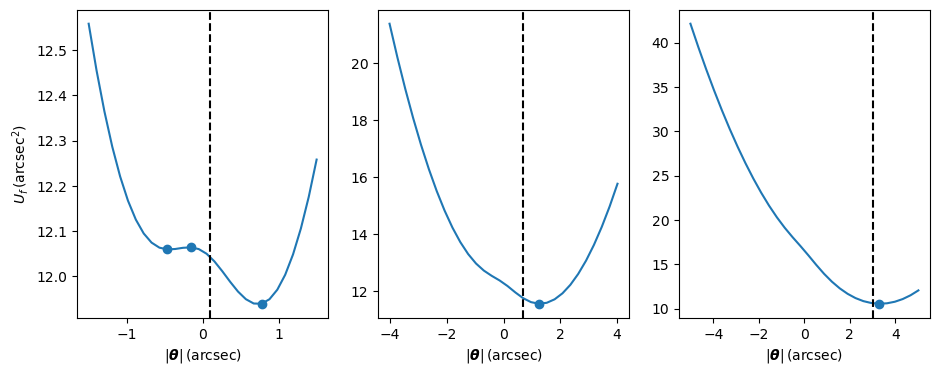

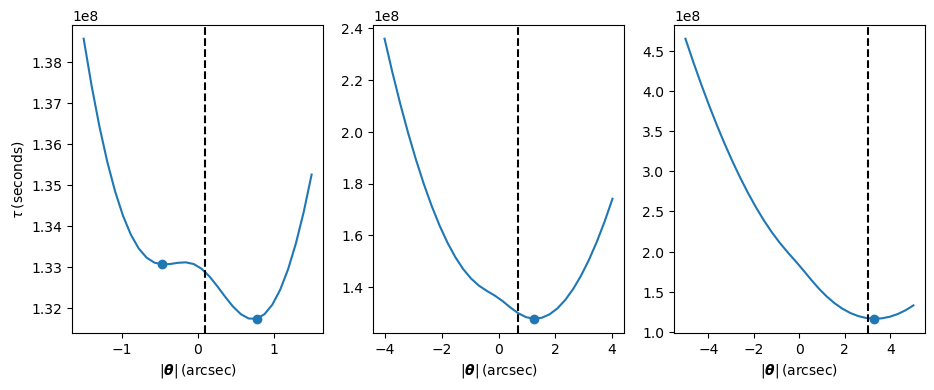

In [39]:
from galpy.potential import PerfectEllipsoidPotential
pep = PerfectEllipsoidPotential(amp=5*10.**11*u.Msun,a=4*u.kpc,b=1.,c=1.)
betas= [0.1,0.7,3.0]
plt.figure(figsize=(11,4))
for ii,beta in enumerate(betas):
    plt.subplot(1,len(betas),ii+1)
    if np.fabs(beta) < 0.5:
        thetas= np.linspace(-1.5,1.5,30)*u.arcsec
    elif np.fabs(beta) < 1.5:
        thetas= np.linspace(-4.01,4.01,30)*u.arcsec
    else:
        thetas= np.linspace(-5.01,5.01,30)*u.arcsec
    ploty= u.Quantity([fermat_potential(pep,u.Quantity([beta,0.])*u.arcsec,
                                      u.Quantity([theta,0.*u.arcsec]),
                                      zlens,zsource).to(u.arcsec**2)
                       for theta in thetas])
    line= plt.plot(thetas,ploty)
    plt.plot(*extrema(thetas,ploty),'o',color=line[0].get_color())
    plt.axvline(beta,color='k',ls='--')
    plt.xlabel(r'$|\boldsymbol{\theta}|\,(\mathrm{arcsec})$')
    if ii == 0:
        plt.ylabel(r'$U_f\,(\mathrm{arcsec}^2)$');

plt.show()
plt.figure(figsize=(11,4))
for ii,beta in enumerate(betas):
    plt.subplot(1,len(betas),ii+1)
    if np.fabs(beta) < 0.5:
        thetas= np.linspace(-1.5,1.5,30)*u.arcsec
    elif np.fabs(beta) < 1.5:
        thetas= np.linspace(-4.01,4.01,30)*u.arcsec
    else:
        thetas= np.linspace(-5.01,5.01,30)*u.arcsec
    ploty2= u.Quantity([arrival_time(pep,u.Quantity([beta,0.])*u.arcsec,
                                      u.Quantity([theta,0.*u.arcsec]),
                                      zlens,zsource).to(u.second,equivalencies=u.dimensionless_angles())
                       for theta in thetas])
    line= plt.plot(thetas,ploty2)
    plt.plot(*minima(thetas,ploty2),'o',color=line[0].get_color())
    plt.axvline(beta,color='k',ls='--')
    plt.xlabel(r'$|\boldsymbol{\theta}|\,(\mathrm{arcsec})$')
    if ii == 0:
        plt.ylabel(r'$\tau\,(\mathrm{seconds})$');
plt.show()